In [1]:
%matplotlib notebook
import numpy as np
from lmfit import Parameters, Minimizer, report_fit
import os
from scipy.integrate import ode
from scipy.optimize import brentq
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("/home/pablo/CinePy")
from constantes.lectura import lee_constantes_retardados
from constantes.constantes_reactores import RA3 as REACTOR
from modules.point_kinetics.reactimeter import reactimetro
from modules.point_kinetics.ajuste_CEM import lee_archivo_CIN, deteccion_borde, \
                                              salto_instantaneo_espacial

# Solución de la cinética puntual para un salto en escalón

In [2]:
# Se leen juego de cosntantes nucleares de neutrones retardados
b, lam , beta = lee_constantes_retardados('Tuttle')

from constantes.constantes_reactores import RA3 as REACTOR
# Se leen constantes características de cada reactor
Lambda_red = REACTOR.LAMBDA_REDUCIDO

constantes_cineticas = b, lam, Lambda_red

## Solución analítica de un salto en escalón de reactividad

Para un reactor inicialmente crítico y estacionario en un valor $n_0$ (sin fuente externa de neutrones), a un tiempo $t_0$ se produce un cambio de reactividad $\$_0$ de forma instantánea.

La solución exacta de esta evolución es:

\begin{align}
n(t < t_0 ) &= 1 \\
n(t\ge t_0) &= A_1 \sum_{i=1}^7 B_i e^{\omega_i (t-t_0)} + A_3
\end{align}


donde los coeficientes $B_i$ se definen como:

\begin{equation}
B_i = \frac{\$_0 / \omega_i}{\Lambda^*  + \sum_{j=1}^6 \frac{b_j\lambda_j}{(\omega_i + \lambda_j)^2}}
\end{equation}

y los $\omega_i$ son las soluciones de la ecuación in-hour:

\begin{equation}
\$_0 = \Lambda^* \omega + \omega \sum_{i=1}^6 \frac{b_i}{\omega + \lambda_i}
\end{equation}

# Ajuste de datos medidos

In [3]:
# Defino la función objetivo

def residual_analitico(params, t, data=None, sigma=None, constantes=None):
    parvals = params.valuesdict()
    rho = parvals['rho']
    t0 = parvals['t0']
    n0 = parvals['n0']
    A1 = parvals['A1']
    A3 = parvals['A3']

    model = salto_instantaneo_espacial(t, rho, t0, n0, A1, A3, constantes) 

    if data is None:
        return model
    if sigma is None:
        return model - data
    return (model - data) / sigma

<IPython.core.display.Javascript object>


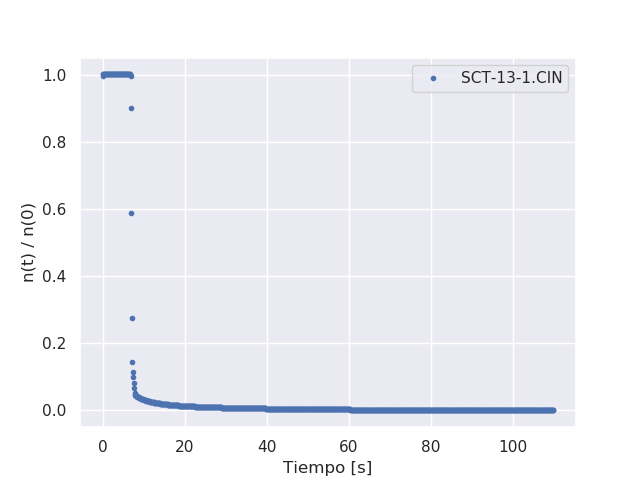

In [4]:
folder = "data"

#archivo = "S-B23A-1.CIN"
#archivo = "S-B23A-2.CIN"
archivo = "SCT-13-1.CIN"
#archivo = "SCT-13-2.CIN"

file_path = os.path.join(folder, archivo)

t_cin, n_cin = lee_archivo_CIN(file_path)

# Normalizo con el promedio de los primeros 2s
n_cin_nor = n_cin / np.mean(n_cin[t_cin<=2])

fig5, ax5 = plt.subplots(1)
ax5.plot(t_cin, n_cin_nor, '.', label=archivo)
ax5.set_xlabel(r'Tiempo [s]')
ax5.set_ylabel(r'n(t) / n(0)')
ax5.legend()
plt.show()

In [5]:
t_cero = deteccion_borde(t_cin, n_cin, (0.1,3), 'bajada', 3.5)
print(t_cero)

6.7142883


In [6]:
# Parametros iniciales

t_b_fercin = 0.25
#t_b_fercin = 0.27
#t_b_fercin = 0.38

param_ini = -3, t_cero + t_b_fercin , 1, 1, 0

# Se definen los parámetros del ajuste
params = Parameters()
params.add('rho', value=param_ini[0])
params.add('t0', value=param_ini[1], vary=False)
params.add('n0', value=param_ini[2], vary=False)
params.add('A1', value=param_ini[3])
params.add('A3', value=param_ini[4])

# Selección del intervalo de ajuste
_t_in = 6
_t_fin = 80

ind_fit = (t_cin >= t_cero + _t_in) & (t_cin <= t_cero + _t_fin)
t_fit = t_cin[ind_fit]
n_cin_fit = n_cin_nor[ind_fit]
# Se define la minimización
minner = Minimizer(residual_analitico, params,
                   fcn_args=(t_fit,),
                   fcn_kws={'data': n_cin_fit, 'constantes':constantes_cineticas},
                   ) 

# Se realiza la minimización de la función objetivo
# metodos = 'nelder', 'leastsq'
metodos = 'leastsq',
results = [minner.minimize(method=metodo) for metodo in metodos]
[report_fit(result) for result in results]
print(80*'-')
print("Archivo analizado: {}".format(archivo))
!cat data/resultados_fercin4.txt

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 672
    # variables        = 3
    chi-square         = 1.4035e-07
    reduced chi-square = 2.0979e-10
    Akaike info crit   = -14972.4562
    Bayesian info crit = -14958.9254
[[Variables]]
    rho: -15.1313299 +/- 0.22584295 (1.49%) (init = -3)
    t0:   6.964288 (fixed)
    n0:   1 (fixed)
    A1:   0.99456211 +/- 0.01470538 (1.48%) (init = 1)
    A3:  -0.00124238 +/- 1.9920e-06 (0.16%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, A1) = -1.000
    C(rho, A3) = -0.875
    C(A1, A3)  =  0.872
--------------------------------------------------------------------------------
Archivo analizado: SCT-13-1.CIN

archivo       t_0        t_b             A3          $m       $i       $d        $p         EE

S-B23A-1     3.295    0.278(33)    -0.797(52)e-4    4.25(2)   5.63    5.94    5.524(6)    30.1
S-B23A-2     3.295    0.269(51)     0.1122(8)e-2    4.24(2)

<IPython.core.display.Javascript object>


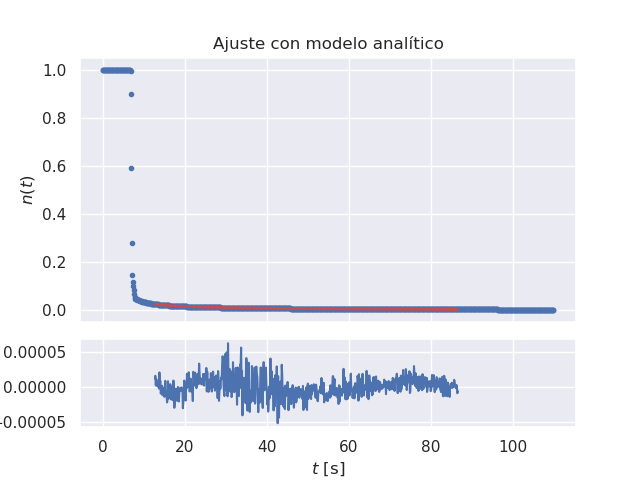

<IPython.core.display.Javascript object>


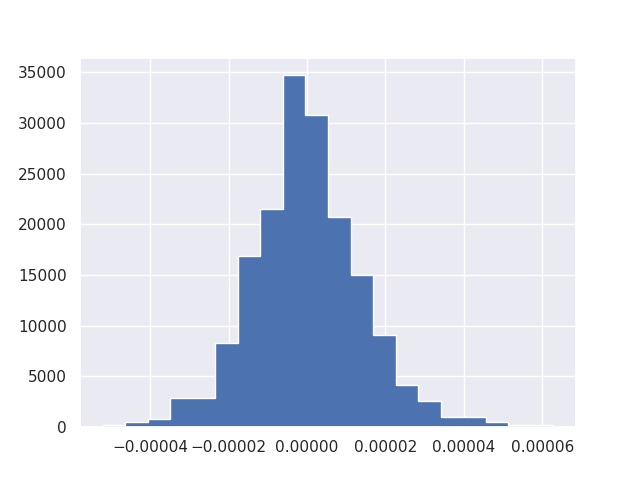

In [7]:
result = results[-1]
best_fit = n_cin_fit + result.residual 

fig, (ax0, ax1) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]},
                               )
# Grafico de ajuste
ax0.errorbar(t_cin, n_cin_nor, fmt='.', elinewidth=2,
             label='measurement', capsize=4)
ax0.plot(t_fit, best_fit, 'r', zorder=3, label='fit', lw=2)
ax0.set_ylabel(r'$n(t)$')
ax0.set_title('Ajuste con modelo analítico')

# Gráfico de residuos
ax1.plot(t_fit, result.residual )
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'Residuals')
fig.subplots_adjust(hspace=0.1)

# Graficación del histograma de los residuos
fig2, ax3 = plt.subplots(1, 1)
ax3.hist(result.residual, bins=20, density=True, label='Residuals',
         histtype='stepfilled')
res_mean = np.mean(result.residual)
res_std = np.std(result.residual, ddof=1)
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 500)

In [8]:
def ajuste_cambiando_cosas(t_o, tiempo_i, tiempo_f):
    
    # Selección del intervalo de ajuste
    _t_in = t_o + tiempo_i
    _t_fin = t_o + tiempo_f
    ind_fit = (t_cin >= _t_in) & (t_cin <= _t_fin)
    t_fit = t_cin[ind_fit]
    n_cin_fit = n_cin_nor[ind_fit]
    # Se define la minimización
    minner = Minimizer(residual_analitico, params,
                       fcn_args=(t_fit,),
                       fcn_kws={'data': n_cin_fit, 'constantes': constantes_cineticas},
                       ) 
    
    # Se realiza la minimización de la función objetivo
    # metodos = 'nelder', 'leastsq'
    metodos = 'leastsq',
    results = [minner.minimize(method=metodo) for metodo in metodos]
    return results[-1]

## Cambiando el tiempo final del ajuste

<IPython.core.display.Javascript object>


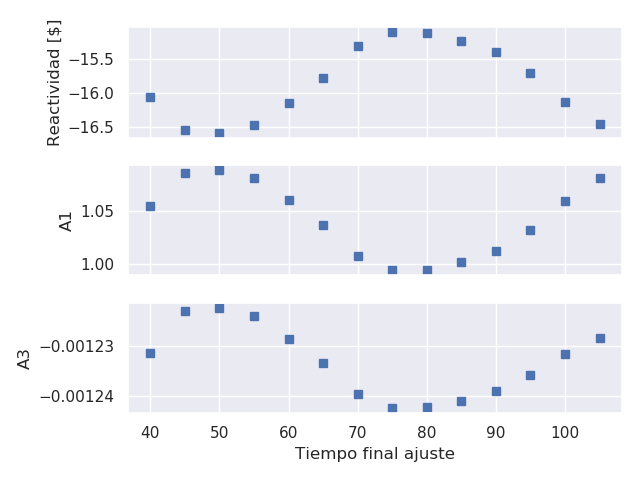

In [9]:
t_0_fijo = t_cero
t_i_fijo = 6
tfs = []
rhos = []
A1s = []
A3s = []
for tf in range(40,110, 5):
    tfs.append(tf)
    resultado = ajuste_cambiando_cosas(t_0_fijo, t_i_fijo, tf)
    rhos.append(resultado.params['rho'].value)
    A1s.append(resultado.params['A1'].value)
    A3s.append(resultado.params['A3'].value)

fig7, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(tfs, rhos, 's')
axs[0].set_ylabel(r"Reactividad [$]")
axs[1].plot(tfs, A1s, 's')
axs[1].set_ylabel(r"A1")
axs[2].plot(tfs, A3s, 's')
axs[2].set_ylabel(r"A3")
axs[2].set_xlabel(r"Tiempo final ajuste")
fig7.tight_layout()

## Cambiando el tiempo inicial del ajuste

<IPython.core.display.Javascript object>


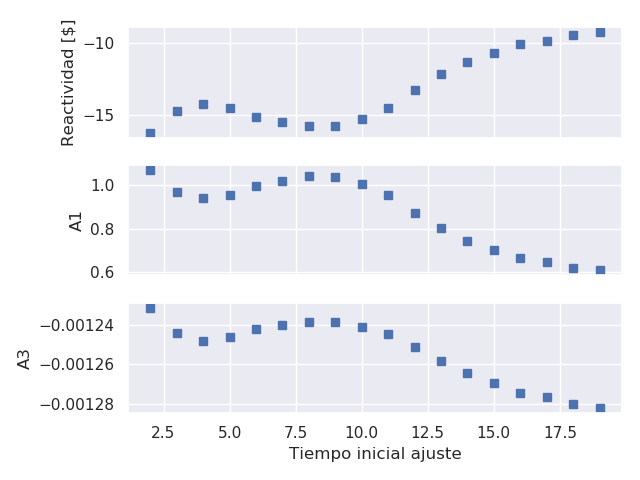

In [10]:
t_0_fijo = t_cero
t_f_fijo = 80
tis = []
rhos = []
A1s = []
A3s = []
for ti in range(2, 20, 1):
    tis.append(ti)
    resultado = ajuste_cambiando_cosas(t_0_fijo, ti, t_f_fijo)
    rhos.append(resultado.params['rho'].value)
    A1s.append(resultado.params['A1'].value)
    A3s.append(resultado.params['A3'].value)

fig7, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(tis, rhos, 's')
axs[0].set_ylabel(r"Reactividad [$]")
axs[1].plot(tis, A1s, 's')
axs[1].set_ylabel(r"A1")
axs[2].plot(tis, A3s, 's')
axs[2].set_ylabel(r"A3")
axs[2].set_xlabel(r"Tiempo inicial ajuste")
fig7.tight_layout()